# Localize flying fish by RSSI in 2D

In [1]:
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## RSSI vs distance

http://electronics.stackexchange.com/questions/83354/calculate-distance-from-rssi

In [2]:
def dist_to_rssi(d, a, n=2.7):
    """
    Compute rssi of an emitter given a distance
    
    rssi = -10 * n * log10(d) + A
    or
    d = 10^ ( -(rssi - A) / (10 * n))
    
    :param d: distance from emitter
    :param n: propagation constant or path-loss exponent i.e. 2.7 to 4.3 (Free space has n =2 for reference)
    :param a: received signal strength in dBm at 1 meter
    
    http://electronics.stackexchange.com/questions/83354/calculate-distance-from-rssi
    """    
    return -10 * n * np.log(d)/np.log(10) + a

In [3]:
def rssi_to_dist(s, a, n=2.7):
    """
    Compute distance to an emitter given RSSI
    
    rssi = -10 * n * log10(d) + A
    
    d = 10^ ( -(rssi - A) / (10 * n))
    
    :param s: RSSI in dBm
    :param n: propagation constant or path-loss exponent i.e. 2.7 to 4.3 (Free space has n =2 for reference)
    :param a: received signal strength in dBm at 1 meter
    
    http://electronics.stackexchange.com/questions/83354/calculate-distance-from-rssi
    """    
    return np.power(10.0, -0.1 * (s - a) / n)

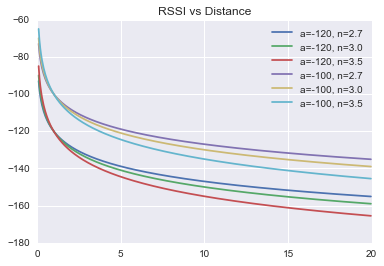

In [4]:
x = np.arange(0.10, 20.0, 0.05)
plt.plot(x, dist_to_rssi(x, a=-120, n=2.7), label='a=-120, n=2.7')
plt.plot(x, dist_to_rssi(x, a=-120, n=3.0), label='a=-120, n=3.0')
plt.plot(x, dist_to_rssi(x, a=-120, n=3.5), label='a=-120, n=3.5')
plt.plot(x, dist_to_rssi(x, a=-100, n=2.7), label='a=-100, n=2.7')
plt.plot(x, dist_to_rssi(x, a=-100, n=3.0), label='a=-100, n=3.0')
plt.plot(x, dist_to_rssi(x, a=-100, n=3.5), label='a=-100, n=3.5')
plt.title('RSSI vs Distance')
plt.legend()

In [5]:
def points_2d_from_rssi(s, rssi_to_dist_f, beacon_pos=(0.0,0.0)):
    d = rssi_to_dist_f(s)
    angles = np.arange(0.0, 360.0, 1.0)
    pts = np.zeros((len(angles), 2))
    pts[:, 0] = beacon_pos[0] + d * np.cos(angles)
    pts[:, 1] = beacon_pos[1] + d * np.sin(angles)
    return pts

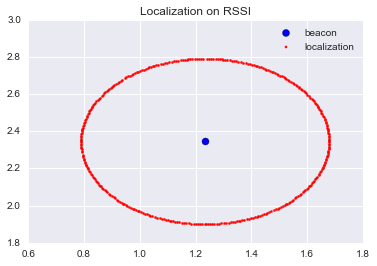

In [6]:
beacon_pos = (1.234, 2.345)
pts = points_2d_from_rssi(-110.5, lambda s: rssi_to_dist(s, a=-120), beacon_pos)
plt.title("Localization on RSSI")
plt.scatter(beacon_pos[0], beacon_pos[1], s=50, label='beacon')
plt.scatter(pts[:,0], pts[:,1], color='r', s=5, label='localization')
plt.legend()

## Multiple beacon case

In [7]:
beacon_positions = np.array([
    [-12.34, 0.0],
    [-2.345, 5.67],
    [3.456, 6.789],
    [13.456, 1.234],
])

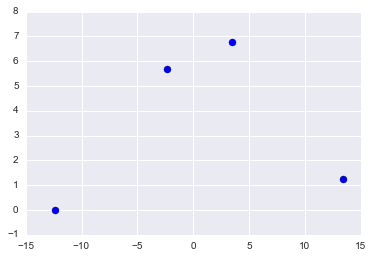

In [8]:
plt.scatter(beacon_positions[:, 0], beacon_positions[:, 1], s=50)

In [9]:
signals = np.array([
    -150,
    -141,
    -140,
    -148
])
rssi_to_dist_f_list = [
    lambda s: rssi_to_dist(s, a=-120),
    lambda s: rssi_to_dist(s, a=-120),
    lambda s: rssi_to_dist(s, a=-120),
    lambda s: rssi_to_dist(s, a=-120), 
]

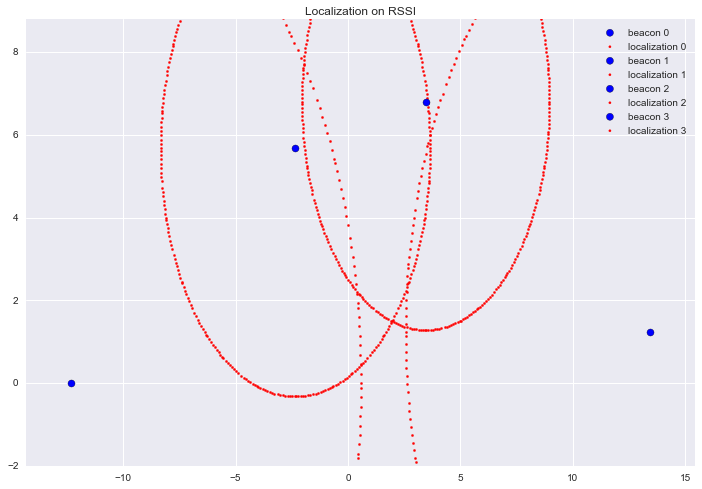

In [10]:
plt.figure(figsize=(12, 8))
for i, s in enumerate(signals):
    beacon_pos = beacon_positions[i]
    pts = points_2d_from_rssi(s, rssi_to_dist_f_list[i], beacon_pos)
    plt.title("Localization on RSSI")
    plt.scatter(beacon_pos[0], beacon_pos[1], s=50, label='beacon %i' % i)
    plt.scatter(pts[:,0], pts[:,1], color='r', s=5, label='localization %i' % i)
plt.legend()
plt.xlim(np.min(beacon_positions[:,0]) - 2.0, np.max(beacon_positions[:,0]) + 2.0)
_ = plt.ylim(np.min(beacon_positions[:,1]) - 2.0, np.max(beacon_positions[:,1]) + 2.0)

In [15]:
def compute_position(signals, rssi_to_dist_f_list, beacon_positions, gamma=0.01, init_pos=(0.0, 0.0), n=100, verbose=0):
    """
    Method to compute localization on received signal
    
    p <- p - gamma * sum_i( p - estimated_positions[i])
    estimated_positions[i, j] = rssi_to_dist_f_list[i](signals[i]) * unit_vector(p[j] - beacon_positions[i, j]) + beacon_positions[i, j] 
    where i goes over beacons, j is [0, 1]   
    """
    assert len(signals) == len(rssi_to_dist_f_list) == len(beacon_positions), "WTF"
    
    def _unit_vector(v):
        return v / np.linalg.norm(v)
    
    distances = [rssi_to_dist_f_list[i](signals[i]) for i in range(len(signals))]
    if verbose > 2:
        print "--- Distances: ", distances
        
    def _update_estimated_positions(estimated_positions, p):
        for i in range(len(estimated_positions)):
            d = distances[i]
            uv = _unit_vector(p - beacon_positions[i, :])
            if verbose > 2: 
                print "Unit vector: ", uv 
            estimated_positions[i, :] = d * uv + beacon_positions[i, :]
        
    p = list(init_pos)
    estimated_positions = np.zeros((len(signals), 2))
    if verbose > 0:
        print "- Initial position, ", p
    for i in range(n):
        _update_estimated_positions(estimated_positions, p)
        if verbose > 2:
            print "-- Estimated positions : ", estimated_positions
        p[0] -= gamma * np.sum(p[0] - estimated_positions[:, 0])
        p[1] -= gamma * np.sum(p[1] - estimated_positions[:, 1])        
        if verbose > 1:
            print i, "-- Update ", p    
    if verbose > 0:
        print "- Computed ", p
    return p

In [17]:
p = compute_position(signals, rssi_to_dist_f_list, beacon_positions, gamma=0.1, n=100, verbose=0)
p

[1.6226472387400181, 1.3569084512885359]

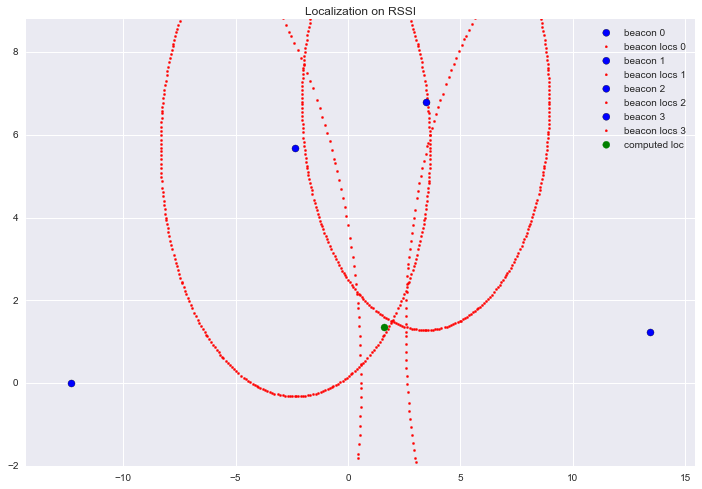

In [18]:
plt.figure(figsize=(12, 8))
for i, s in enumerate(signals):
    beacon_pos = beacon_positions[i]
    pts = points_2d_from_rssi(s, rssi_to_dist_f_list[i], beacon_pos)
    plt.title("Localization on RSSI")
    plt.scatter(beacon_pos[0], beacon_pos[1], s=50, label='beacon %i' % i)
    plt.scatter(pts[:,0], pts[:,1], color='r', s=5, label='beacon locs %i' % i)

plt.scatter(p[0], p[1], color='g', s=50, label='computed loc')
plt.legend()
plt.xlim(np.min(beacon_positions[:,0]) - 2.0, np.max(beacon_positions[:,0]) + 2.0)
_ = plt.ylim(np.min(beacon_positions[:,1]) - 2.0, np.max(beacon_positions[:,1]) + 2.0)


# Localize flying fish by RSSI in 3D

In [25]:
import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline

In [108]:
def points_3d_from_rssi(s, rssi_to_dist_f, beacon_pos=(0.0, 0.0, 0.0)):
    d = rssi_to_dist_f(s)
    phi = np.arange(0.0, 360.0, 5.0)
    thetas = np.arange(0.0, 180.0, 5.0)    
    pts = np.zeros((len(phi) * len(thetas), 3))
    for i, theta in enumerate(thetas):
        indices = i * len(phi) +  np.arange(len(phi))
        pts[indices, 0] = beacon_pos[0] + d * np.cos(phi) * np.sin(theta)
        pts[indices, 1] = beacon_pos[1] + d * np.sin(phi) * np.sin(theta)
        pts[indices, 2] = beacon_pos[2] + d * np.cos(theta)    
    return pts

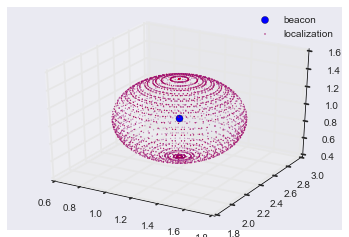

In [109]:
beacon_pos = (1.234, 2.345, 1.0)
pts = points_3d_from_rssi(-110.5, lambda s: rssi_to_dist(s, a=-120), beacon_pos)
plt.title("Localization on RSSI")
ax = plt.subplot(111, projection='3d')
ax.scatter(beacon_pos[0], beacon_pos[1], beacon_pos[2], s=50, label='beacon')
ax.scatter(pts[:,0], pts[:,1], pts[:, 2], color='r', s=1, label='localization')
plt.legend()

## Multiple beacon case

In [79]:
beacon_positions = np.array([
    [-12.34, 0.0, 1.0],
    [-2.345, 5.67, 1.0],
    [3.456, 6.789, 1.0],
    [13.456, 1.234, 1.0],
])

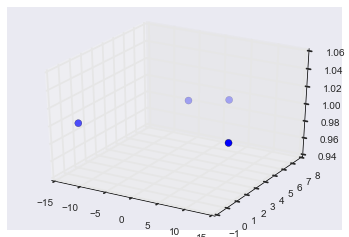

In [80]:
ax = plt.subplot(111, projection='3d')
ax.scatter(beacon_positions[:, 0], beacon_positions[:, 1], beacon_positions[:, 2], s=50, label='beacon')

In [56]:
signals = np.array([
    -150,
    -141,
    -140,
    -148
])
rssi_to_dist_f_list = [
    lambda s: rssi_to_dist(s, a=-120),
    lambda s: rssi_to_dist(s, a=-120),
    lambda s: rssi_to_dist(s, a=-120),
    lambda s: rssi_to_dist(s, a=-120), 
]

In [96]:
help(ax.view_init)

Help on method view_init in module mpl_toolkits.mplot3d.axes3d:

view_init(self, elev=None, azim=None) method of matplotlib.axes._subplots.Axes3DSubplot instance
    Set the elevation and azimuth of the axes.
    
    This can be used to rotate the axes programatically.
    
    'elev' stores the elevation angle in the z plane.
    'azim' stores the azimuth angle in the x,y plane.
    
    if elev or azim are None (default), then the initial value
    is used which was specified in the :class:`Axes3D` constructor.



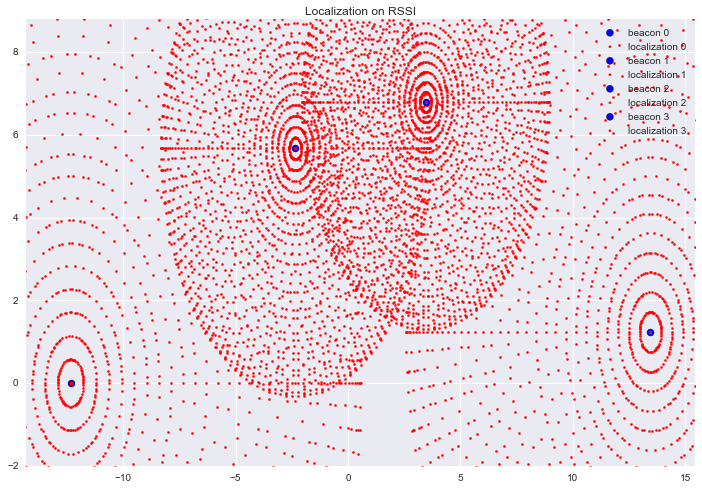

In [110]:
plt.figure(figsize=(12, 8))
for i, s in enumerate(signals):
    beacon_pos = beacon_positions[i]
    pts = points_3d_from_rssi(s, rssi_to_dist_f_list[i], beacon_pos)
    plt.title("Localization on RSSI")
    plt.scatter(beacon_pos[0], beacon_pos[1], s=50, label='beacon %i' % i)
    plt.scatter(pts[:,0], pts[:,1], color='r', s=5, label='localization %i' % i)
plt.legend()
plt.xlim(np.min(beacon_positions[:,0]) - 2.0, np.max(beacon_positions[:,0]) + 2.0)
_ = plt.ylim(np.min(beacon_positions[:,1]) - 2.0, np.max(beacon_positions[:,1]) + 2.0)

In [111]:
def compute_position(signals, rssi_to_dist_f_list, beacon_positions, gamma=0.01, init_pos=(0.0, 0.0, 0.0), n=100, verbose=0):
    """
    Method to compute localization on received signal
    
    p <- p - gamma * sum_i( p - estimated_positions[i])
    estimated_positions[i, j] = rssi_to_dist_f_list[i](signals[i]) * unit_vector(p[j] - beacon_positions[i, j]) + beacon_positions[i, j] 
    where i goes over beacons, j is [0, 1]   
    """
    assert len(signals) == len(rssi_to_dist_f_list) == len(beacon_positions), "WTF"
    
    def _unit_vector(v):
        return v / np.linalg.norm(v)
    
    distances = [rssi_to_dist_f_list[i](signals[i]) for i in range(len(signals))]
    if verbose > 2:
        print "--- Distances: ", distances
        
    def _update_estimated_positions(estimated_positions, p):
        for i in range(len(estimated_positions)):
            d = distances[i]
            uv = _unit_vector(p - beacon_positions[i, :])
            if verbose > 2: 
                print "Unit vector: ", uv 
            estimated_positions[i, :] = d * uv + beacon_positions[i, :]
        
    p = list(init_pos)
    estimated_positions = np.zeros((len(signals), 3))
    if verbose > 0:
        print "- Initial position, ", p
    for i in range(n):
        _update_estimated_positions(estimated_positions, p)
        if verbose > 2:
            print "-- Estimated positions : ", estimated_positions
        p[0] -= gamma * np.sum(p[0] - estimated_positions[:, 0])
        p[1] -= gamma * np.sum(p[1] - estimated_positions[:, 1])
        p[2] -= gamma * np.sum(p[2] - estimated_positions[:, 2])        
        if verbose > 1:
            print i, "-- Update ", p    
    if verbose > 0:
        print "- Computed ", p
    return p

In [120]:
p = compute_position(signals, rssi_to_dist_f_list, beacon_positions, init_pos=(0.0, 0.0, 1.0), gamma=0.1, n=10, verbose=3)
p

--- Distances:  [12.915496650148834, 5.9948425031894104, 5.5047898078549702, 10.8902296226373]
- Initial position,  [0.0, 0.0, 1.0]
Unit vector:  [ 1.  0.  0.]
Unit vector:  [ 0.38218384 -0.92408631  0.        ]
Unit vector:  [-0.4536603  -0.89117469  0.        ]
Unit vector:  [-0.99582132 -0.09132309  0.        ]
-- Estimated positions :  [[ 0.57549665  0.          1.        ]
 [-0.05386805  0.13024811  1.        ]
 [ 0.95869543  1.88327062  1.        ]
 [ 2.61127721  0.23947058  1.        ]]
0 -- Update  [0.40916012417912961, 0.22529893096592812, 1.0]
Unit vector:  [ 0.99984389  0.01766891  0.        ]
Unit vector:  [ 0.45137935 -0.89233216  0.        ]
Unit vector:  [-0.42104392 -0.90704025  0.        ]
Unit vector:  [-0.99702462 -0.07708378  0.        ]
-- Estimated positions :  [[ 0.57348045  0.22820275  1.        ]
 [ 0.36094813  0.32060925  1.        ]
 [ 1.13824174  1.79593406  1.        ]
 [ 2.59817296  0.39453988  1.        ]]
1 -- Update  [0.71258040209899065, 0.409107953010

[1.5204088654573855, 1.1165359796677308, 1.0]

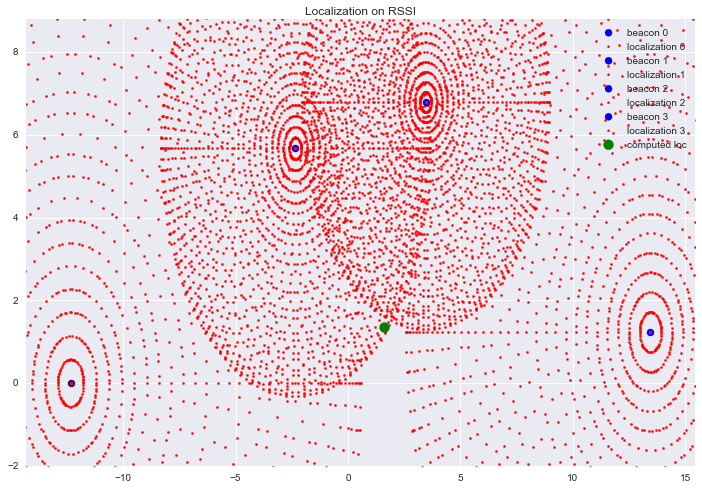

In [116]:
plt.figure(figsize=(12, 8))
for i, s in enumerate(signals):
    beacon_pos = beacon_positions[i]
    pts = points_3d_from_rssi(s, rssi_to_dist_f_list[i], beacon_pos)
    plt.title("Localization on RSSI")
    plt.scatter(beacon_pos[0], beacon_pos[1], s=50, label='beacon %i' % i)
    plt.scatter(pts[:,0], pts[:,1], color='r', s=5, label='localization %i' % i)

plt.scatter(p[0], p[1], color='g', s=100, label='computed loc')    
plt.legend()
plt.xlim(np.min(beacon_positions[:,0]) - 2.0, np.max(beacon_positions[:,0]) + 2.0)
_ = plt.ylim(np.min(beacon_positions[:,1]) - 2.0, np.max(beacon_positions[:,1]) + 2.0)